## Atividade Curta 4 - Treinamento de rede neural usando batch

#### Aluno: 119891 - João Vitor Silva de Oliveira


**Test with Iris dataset and Test and train split function**

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
X, y = iris.data, iris.target

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(X_train[0])
print(y_test[0])

(120, 4)
(30, 4)
(120,)
(30,)
[6.1 3.  4.6 1.4]
0


### Architecture definition

In [2]:
#define ANN architecture as a Torch NN Module

import torch.nn as nn

class ANN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.lin1 = nn.Linear(4, 10)
        self.act1 = nn.ReLU()
        self.lin2 = nn.Linear(10, 20)
        self.act2 = nn.ReLU()
        self.lin3 = nn.Linear(20, num_classes)
        
    def forward(self, x, debug=False):
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.lin1(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.act1(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.lin2(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        x = self.act2(x)
        if debug : print(f'Shape de entrada: {x.shape}')
        y = self.lin3(x)
        if debug : print(f'Shape de entrada: {y.shape}')
        return y         

### Model analysis

In [3]:
import torch

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}.")

net = ANN( num_classes=3 )
#net = ANN()

net = net.to(my_device)

a = torch.rand( (1, 4) )
a = a.to(my_device)
b = net( a , debug=True)

del a, b, net

Running on cuda.
Shape de entrada: torch.Size([1, 4])
Shape de entrada: torch.Size([1, 10])
Shape de entrada: torch.Size([1, 10])
Shape de entrada: torch.Size([1, 20])
Shape de entrada: torch.Size([1, 20])
Shape de entrada: torch.Size([1, 3])


In [4]:
#!pip install torchsummary
from torchsummary import summary

net = ANN( num_classes=3 )

net = net.to(my_device)

summary(net, input_size=(1, 4), batch_size=1)

del net

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 1, 10]              50
              ReLU-2                 [1, 1, 10]               0
            Linear-3                 [1, 1, 20]             220
              ReLU-4                 [1, 1, 20]               0
            Linear-5                  [1, 1, 3]              63
Total params: 333
Trainable params: 333
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Training functions

In [5]:
#!pip install tensorboard


from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

def train ( dataset, prefix=None, upper_bound=101.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=True, lambda_reg=0 ) :
    
    num_classes = 3
    
    tensorboard_path = './tensorboard/'
  
    net = ANN( num_classes )
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    
    accuracies = []
    max_accuracy = -1.0  
    
    data_loader = train_test_split( dataset.data,
                                     dataset.target,
                                     test_size=0.2,
                                     random_state=1 )
    
    train_x,test_x,train_label,test_label = data_loader
    
    train_x = torch.from_numpy(train_x).float()
    train_x = train_x.to(device)
    train_label = torch.from_numpy(train_label).float()
    train_label = train_label.to(device)
    
    test_x = torch.from_numpy(test_x).float()
    test_x = test_x.to(device)
    test_label = torch.from_numpy(test_label).float()
    test_label = test_label.to(device)
    
    writer.add_graph(net, train_x)
    
    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        
        # Set Pytorch variables
        net.train()
        optimizer.zero_grad()
                            
        # Forward step
        predict_y = net( train_x )
        
        # Loss
        error = criterion( predict_y , train_label.long() )

        # Back propagation
        error.backward()
        optimizer.step()

        # Accuracies:
        predict_ys = torch.max( predict_y, axis=1 )[1]
        correct    = torch.sum( predict_ys == train_label )
        accuracy_train = correct/train_x.size(0)
        
        accuracy_test = validate(net, test_x, test_label, device=device)
        accuracies.append(accuracy_test)
        
        # Tensor board writing
        writer.add_scalar( 'Loss/train', error.item(), epoch )
        writer.add_scalar( 'Accuracy/train', accuracy_train, epoch )
        writer.add_scalar( 'Accuracy/test', accuracy_test, epoch )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        # Test model
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy_test
            print(f'Saving the best model at epoch {epoch+1:3d} ' + 
                    f'with Accuracy: {accuracy_test:8.4f}%')
      
        if debug : print( f'Epoch: {epoch+1:3d} |' 
                         + f'Accuracy Test: {accuracy_test:3.4f}%' )

        if accuracy_test > upper_bound :
            break
   
    if save : 
        models_path = './models/'
        path = f'{models_path}{prefix}-{max_accuracy:.2f}.pkl'
        torch.save( best_model, path )
        print( f'Model saved in: {path}' )
  
    plt.figure(figsize=(16, 8))
    plt.plot(accuracies)

    writer.flush()
    writer.close()

    return best_model

In [6]:
def validate ( model , test_x, test_label , device='cpu') :

    model.eval()

    predict_y = model( test_x ).detach()
    predict_ys = torch.max( predict_y, axis=1 )[1]
    correct = torch.sum(predict_ys == test_label)
  
    return correct.to('cpu').numpy()*100./test_x.size(0)

In [7]:
def plot_layers ( net , writer, epoch ) :
    layers = list(net.modules())

    layer_id = 1
    for layer in layers:
        if isinstance(layer, nn.Linear) :
            writer.add_histogram(f'Bias/linear-{layer_id}', layer.bias, epoch )
            writer.add_histogram(f'Weight/linear-{layer_id}', layer.weight, epoch )
            writer.add_histogram(f'Grad/linear-{layer_id}', layer.weight.grad, epoch )
            layer_id += 1

### Run the training phase

Running on cuda


Training epochs...:   2%|▏         | 8/500 [00:00<00:12, 39.05it/s]

Saving the best model at epoch   1 with Accuracy:  43.3333%
Saving the best model at epoch  11 with Accuracy:  53.3333%
Saving the best model at epoch  12 with Accuracy:  56.6667%


Training epochs...:   5%|▌         | 26/500 [00:00<00:08, 52.80it/s]

Saving the best model at epoch  23 with Accuracy:  60.0000%
Saving the best model at epoch  27 with Accuracy:  96.6667%


Training epochs...:  53%|█████▎    | 263/500 [00:05<00:04, 48.67it/s]

Saving the best model at epoch 255 with Accuracy: 100.0000%


Training epochs...: 100%|██████████| 500/500 [00:10<00:00, 48.59it/s]


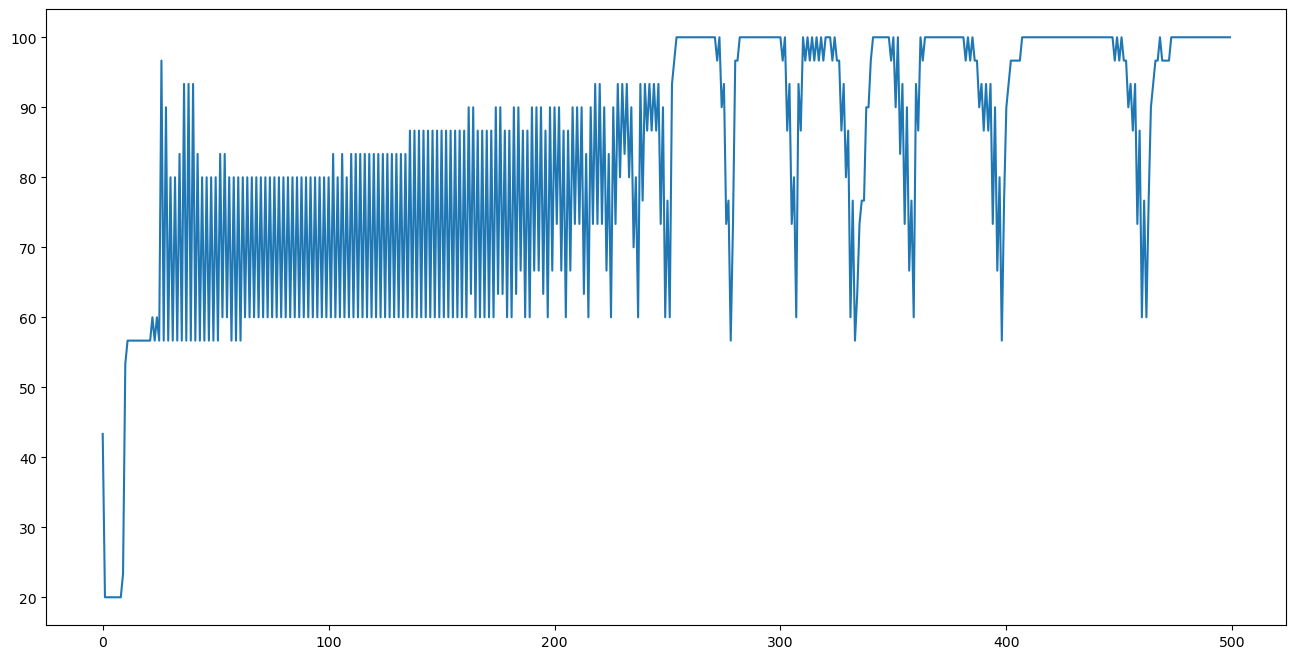

In [8]:
from sklearn.datasets import load_iris

if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
    
print(f"Running on {my_device.type}")
    
dataset = 'Iris'
epochs = 500
lr = 1e-1
lambda_reg = 1e-4
prefix = 'ANN-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

iris = load_iris()
dataset = iris

net = train( dataset=dataset, epochs=epochs, device=my_device, 
            upper_bound=100.0, lr=lr, lambda_reg=lambda_reg,
            layers2tensorboard=True, save=False, prefix=prefix
           )

In [9]:
print(net)

import numpy as np

test_x = torch.from_numpy(X_test).float()
test_x = test_x.to(my_device)
test_label = torch.from_numpy(y_test).float()
test_label = test_label.to(my_device)

indice  = np.random.randint(0,30)

print(test_x[indice])
output = net(test_x[indice])
print(output)
predictedd_class = torch.max(output, dim=0)[1]

print(f'saida do modelo: {predictedd_class.to('cpu').numpy()} e saída correta {y_test[indice]} para o indice {indice}')

ANN(
  (lin1): Linear(in_features=4, out_features=10, bias=True)
  (act1): ReLU()
  (lin2): Linear(in_features=10, out_features=20, bias=True)
  (act2): ReLU()
  (lin3): Linear(in_features=20, out_features=3, bias=True)
)
tensor([6.9000, 3.1000, 5.1000, 2.3000], device='cuda:0')
tensor([-6.2318,  2.8725,  3.7826], device='cuda:0', grad_fn=<ViewBackward0>)
saida do modelo: 2 e saída correta 2 para o indice 6


# Training with Batches

In [10]:
from torch.utils.data import DataLoader, TensorDataset

def train_with_batches ( dataset, prefix=None, upper_bound=101.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=True, lambda_reg=0, batch_size=16 ) :
    
    num_classes = 3
    
    tensorboard_path = './tensorboard/'
  
    net = ANN( num_classes )
    net.to(device)

    optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=lambda_reg)
    criterion = nn.CrossEntropyLoss()

    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
    
    accuracies = []
    max_accuracy = -1.0  
    
    data_loader = train_test_split( dataset.data,
                                     dataset.target,
                                     test_size=0.2,
                                     random_state=1 )
    
    train_x,test_x,train_label,test_label = data_loader
    
    train_x = torch.from_numpy(train_x).float()
    train_x = train_x.to(device)
    train_label = torch.from_numpy(train_label).long()
    train_label = train_label.to(device)
    
    test_x = torch.from_numpy(test_x).float()
    test_x = test_x.to(device)
    test_label = torch.from_numpy(test_label).long()
    test_label = test_label.to(device)
    
    train_dataset = TensorDataset(train_x, train_label)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm( range(epochs) , desc='Training epochs...' ) :
        
        net.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = net(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
            epoch_loss += loss.item() * batch_x.size(0)
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
        
        accuracy_train = correct / total

        
        accuracy_test = validate(net, test_x, test_label, device=device)
        accuracies.append(accuracy_test)
        
        # Tensor board writing
        writer.add_scalar( 'Loss/train', epoch_loss/total, epoch )
        writer.add_scalar( 'Accuracy/train', accuracy_train, epoch )
        writer.add_scalar( 'Accuracy/test', accuracy_test, epoch )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        # Test model
        if accuracy_test > max_accuracy:
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy_test
            print(f'Saving the best model at epoch {epoch+1:3d} ' + 
                    f'with Accuracy: {accuracy_test:8.4f}%')
      
        if debug : print( f'Epoch: {epoch+1:3d} |' 
                         + f'Accuracy Test: {accuracy_test:3.4f}%' )

        if accuracy_test > upper_bound :
            break
   
    if save : 
        models_path = './models/'
        path = f'{models_path}{prefix}-{max_accuracy:.2f}.pkl'
        torch.save( best_model, path )
        print( f'Model saved in: {path}' )
  
    plt.figure(figsize=(16, 8))
    plt.plot(accuracies)

    writer.flush()
    writer.close()

    return best_model

Running on cuda


Training epochs...:   1%|          | 4/500 [00:00<00:14, 33.08it/s]

Saving the best model at epoch   1 with Accuracy:  56.6667%
Saving the best model at epoch   2 with Accuracy:  60.0000%
Saving the best model at epoch   4 with Accuracy:  73.3333%
Saving the best model at epoch   5 with Accuracy:  96.6667%


Training epochs...:   5%|▍         | 24/500 [00:00<00:13, 35.22it/s]

Saving the best model at epoch  19 with Accuracy: 100.0000%


Training epochs...: 100%|██████████| 500/500 [00:14<00:00, 35.00it/s]


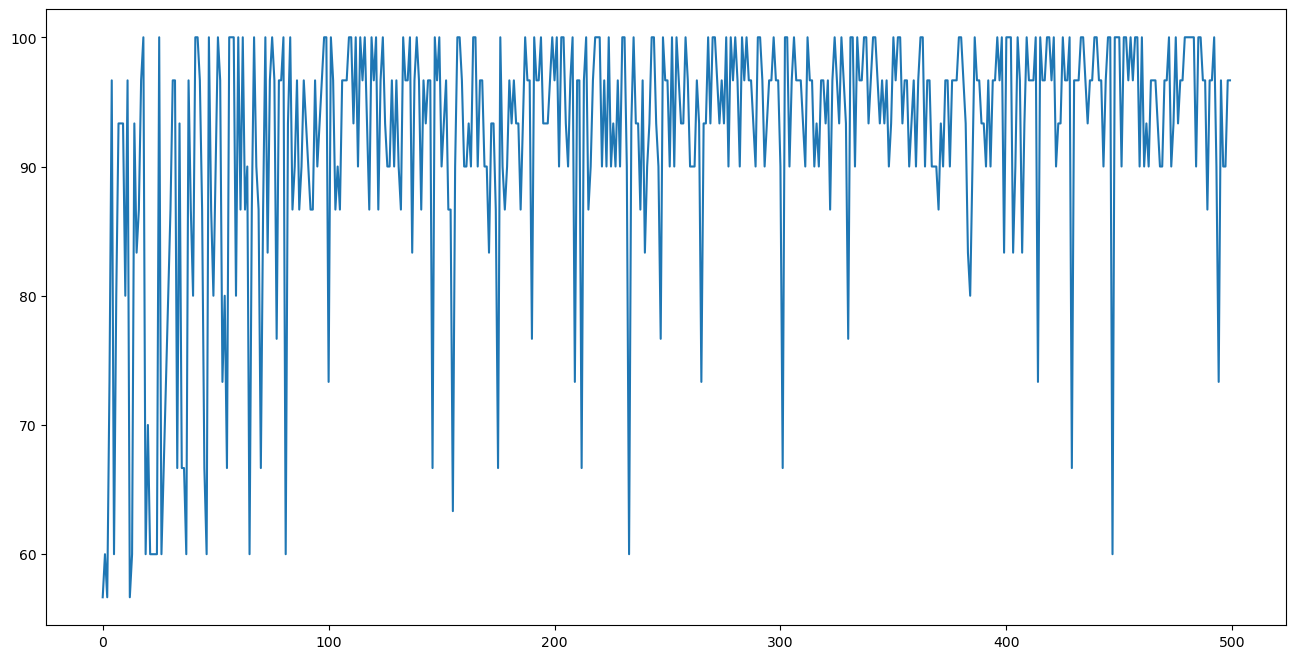

In [11]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")
    
print(f"Running on {my_device.type}")
    
dataset = 'Iris'
epochs = 500
lr = 1e-1
lambda_reg = 1e-4
prefix = 'BS-ANN-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

iris = load_iris()
dataset = iris

net = train_with_batches( dataset=dataset, epochs=epochs, device=my_device, 
            upper_bound=101.0, lr=lr, lambda_reg=lambda_reg,
            layers2tensorboard=True, save=False, prefix=prefix, batch_size=16
           )

# Analysis of Results
From the analysis of the results, it is evident that training using batches achieved significantly faster convergence compared to training with the entire dataset. While the model trained with batches reached 100% test accuracy as early as epoch 19, the model trained on the full dataset required 255 epochs to achieve the same performance. This difference highlights how the stochastic noise introduced by batches can accelerate the optimization process and promote earlier generalization, even with a slight loss in gradient precision per epoch. Therefore, in terms of learning efficiency, batch training proved to be considerably more advantageous in this scenario.